<a href="https://colab.research.google.com/github/protoi/Speech-Emotion-Analysis/blob/main/3_1_Categorical_Data_for_BandPass_Filtering_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCRIPTION 

Uses the .pickle file generated from the previous code, passes the audio time series through a band pass filter and produces spectrograms.

# LIBRARIES AND IMPORTS

In [ ]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
import librosa as lib
import librosa.display as lid
import re 
import os as os
import glob as glob
from pathlib import Path
from os import chdir
from scipy.signal import butter, filtfilt
import gc
from tqdm import tqdm
from google.colab import drive
import shutil
from google.colab import output
import IPython
from IPython.display import Audio
import random as rand
from pylab import Rectangle
import gc 
from scipy import stats
import soundfile as sf
import pyarrow.feather as feather
from scipy.signal import butter
from scipy.signal import butter, filtfilt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOADING AND DESERIALIZING THE PICKLE FILE

In [ ]:
# !cp /content/drive/MyDrive/Machine\ Learning/Speech\ Emotion\ Recognition/audio_without_silence.pkl /content/audio_without_silence.pkl
df = None
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning/Speech Emotion Recognition/audio_without_silence.pkl")
df

,labels,source,path,name,silence_removed
0,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a01.wav,DC_a01,"[0.112091064, 0.11282349, 0.088012695, 0.05386..."
1,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a02.wav,DC_a02,"[0.10910034, 0.11364746, 0.10357666, 0.0806579..."
2,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a03.wav,DC_a03,"[0.12271118, 0.123931885, 0.1251831, 0.1264648..."
3,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a04.wav,DC_a04,"[0.12472534, 0.13046265, 0.13531494, 0.1396484..."
4,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a05.wav,DC_a05,"[0.121795654, 0.1227417, 0.11932373, 0.1135559..."
...,...,...,...,...,...
12157,female_disgust,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_DIS_XX.wav,1091_WSI_DIS_XX,"[0.0009117986, 0.0011943923, 0.0013480312, 0.0..."
12158,female_fear,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_FEA_XX.wav,1091_WSI_FEA_XX,"[-0.0065059913, -0.007563202, -0.0075736893, -..."
12159,female_happy,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_HAP_XX.wav,1091_WSI_HAP_XX,"[0.011431874, 0.011645955, 0.011703809, 0.0115..."
12160,female_neutral,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_NEU_XX.wav,1091_WSI_NEU_XX,"[0.008490561, 0.00867801, 0.008760293, 0.00883..."


# SOME STATISTICS

In [ ]:
length_of_audios = np.array([len(i) for i in df['silence_removed'].values])
print(f'mean: {np.mean(length_of_audios)}')
print(f'median: {np.median(length_of_audios)}')
print(f'mode: {stats.mode(length_of_audios).mode[0]}')
print(f'standard deviation: {np.std(length_of_audios)}')

mean: 77560.97845749055
median: 71158.5
mode: 50852
standard deviation: 26487.01623615346


# ADDING & REMOVING SAMPLES TO MAKE EVERY ARRAY THE LENGTH OF THE MEDIAN

In [ ]:
%%time
#makes length of all audio files = median length
def standardize_length(audio_sample, median_length):
  if len(audio_sample) <= 1:
    # return audio_sample #passing a 1 len array to keep the array jagged, numpy will make an array of arrays into aa 2D array if the length of all the arrays are equal
    yield audio_sample 

  if len(audio_sample) >= median_length: #more audio samples than we need, just slice it
    # return audio_sample[ : median_length]
    yield audio_sample[ : median_length]
  else:                                   # append it to itself till length = median_length
    reps = int(median_length/len(audio_sample))
    # return np.concatenate((np.tile(audio_sample, reps), audio_sample[: median_length % len(audio_sample)]))
    yield np.concatenate((np.tile(audio_sample, reps), audio_sample[: median_length % len(audio_sample)]))

#calls audio normalized, can make it chain call bandpass filter later if needed
def audio_trimming(numpy_array: np.array, target_len) -> np.array:
  return np.array(list(map(lambda x: standardize_length(x, target_len), numpy_array)), dtype=object)

median_len = math.floor(np.median(length_of_audios))


ragged_row = pd.Series({'labels':None, 'source':None, 'path':None, 'name':None, 'silence_removed':np.array([1])})



#comment the three lines below when testing, this is for production
df = pd.concat([df, ragged_row.to_frame().T], ignore_index=True)
df['audio_normalized'] = audio_trimming(df['silence_removed'].values, median_len)
# df['silence_removed'] = None
# df.drop(columns=['silence_removed', 'path'], inplace=True)


#below codes for testing
# df_temp = df.head(10).copy(deep=True)
# df_temp = pd.concat([df_temp, ragged_row.to_frame().T], ignore_index=True)
# df_temp['audio_normalized'] = audio_trimming(df_temp['silence_removed'].values, median_len)
# df_temp

# dont forget to remove the last row from the dataframe, it was only there to make the array ragged

CPU times: user 31.9 ms, sys: 1.69 ms, total: 33.6 ms
Wall time: 34.5 ms


In [ ]:
df

,labels,source,path,name,silence_removed,audio_normalized
0,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a01.wav,DC_a01,"[0.112091064, 0.11282349, 0.088012695, 0.05386...",<generator object standardize_length at 0x7ff2...
1,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a02.wav,DC_a02,"[0.10910034, 0.11364746, 0.10357666, 0.0806579...",<generator object standardize_length at 0x7ff2...
2,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a03.wav,DC_a03,"[0.12271118, 0.123931885, 0.1251831, 0.1264648...",<generator object standardize_length at 0x7ff2...
3,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a04.wav,DC_a04,"[0.12472534, 0.13046265, 0.13531494, 0.1396484...",<generator object standardize_length at 0x7ff2...
4,male_anger,SAVEE,/content/SAVEE/AudioData/DC/a05.wav,DC_a05,"[0.121795654, 0.1227417, 0.11932373, 0.1135559...",<generator object standardize_length at 0x7ff2...
...,...,...,...,...,...,...
12160,female_neutral,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_NEU_XX.wav,1091_WSI_NEU_XX,"[0.008490561, 0.00867801, 0.008760293, 0.00883...",<generator object standardize_length at 0x7ff2...
12161,female_sadness,CREMAD,/content/CREMAD/AudioWAV/1091_WSI_SAD_XX.wav,1091_WSI_SAD_XX,"[0.0006946694, 0.0007136891, 0.0006897674, 0.0...",<generator object standardize_length at 0x7ff2...
12162,None,None,None,None,[1],<generator object standardize_length at 0x7ff2...
12163,None,None,None,None,[1],None


# GENERATING SPECTROGRAMS AND STORING THEM

In [ ]:
def short_time_fourier(audio_data):
  try:
    return lib.amplitude_to_db(
        np.abs(
            lib.stft(
                next(
                    next(
                    call_bandpass(
                        next(
                              audio_data
                             ), 44100
                      )
                    )
                  )
                )
            ), ref=np.max)
  except Exception as e:
    print(e)
    return None



def call_bandpass(data, sampling_rate):
  order_of_filter = 6
  yield filter_signal(data, [128, 8192], sampling_rate, order= order_of_filter)
  #yielding the filtered signal between 128 and 8192 Hz



#butterworth bandpass filter
def butter_bandpass_filter(lowcutoff, highcutoff, samplingRate, order = 2):
  nyquistFreq = 0.5 * samplingRate
  low_normal_cutoff = lowcutoff / nyquistFreq
  high_normal_cutoff = highcutoff / nyquistFreq
  b, a = butter(order, [low_normal_cutoff, high_normal_cutoff], btype = 'band')
  return b, a


#signal filtered
def filter_signal(originalSignal, cutoff_freq, samplingRate, order = 2):
  b,a = butter_bandpass_filter(cutoff_freq[0], cutoff_freq[1], samplingRate, order=order)
  yield filtfilt(b, a, originalSignal)
  # yield filtered_data

In [ ]:
if os.path.exists('/content/spectrograms'):
  shutil.rmtree("/content/spectrograms")
!mkdir spectrograms



copied_df = df.head(3).copy(deep=True)
ragged_row = pd.Series({'labels':None, 'source':None, 'path':None, 'name':None, 'silence_removed':np.array([1]), 'audio_normalized': None})
df = pd.concat([df, ragged_row.to_frame().T], ignore_index=True)


# df.apply(shortTimeFourier, axis=1)



In [ ]:
categories = set(df['labels'])

for cat in categories:
  if cat == None:
    continue
    
  temp_df = pd.DataFrame(columns=['spectrogram_data'])
  temp_df['spectrogram_data'] = df[df['labels'] == cat]['audio_normalized'].map(lambda x: short_time_fourier(x))
  temp_df.to_pickle(f"/content/spectrograms/{cat}.pkl")   #making a pickle file of the dataframe for every emotion
  del(temp_df)
  gc.collect()  

The length of the input vector x must be greater than padlen, which is 39.


In [ ]:
import os as os
print(len(os.listdir('/content/spectrograms')))

16


# ZIPPING THE IMAGES

In [ ]:
!pwd
!zip -r spectrograms.zip spectrograms/*.pkl

/content
  adding: spectrograms/female_anger.pkl (deflated 66%)
  adding: spectrograms/female_calm.pkl (deflated 61%)
  adding: spectrograms/female_disgust.pkl (deflated 67%)
  adding: spectrograms/female_fear.pkl (deflated 65%)
  adding: spectrograms/female_happy.pkl (deflated 66%)
  adding: spectrograms/female_neutral.pkl (deflated 65%)
  adding: spectrograms/female_sadness.pkl (deflated 66%)
  adding: spectrograms/female_surprise.pkl (deflated 62%)
  adding: spectrograms/male_anger.pkl (deflated 69%)
  adding: spectrograms/male_calm.pkl (deflated 61%)
  adding: spectrograms/male_disgust.pkl (deflated 69%)
  adding: spectrograms/male_fear.pkl (deflated 68%)
  adding: spectrograms/male_happy.pkl (deflated 69%)
  adding: spectrograms/male_neutral.pkl (deflated 70%)
  adding: spectrograms/male_sadness.pkl (deflated 68%)
  adding: spectrograms/male_surprise.pkl (deflated 66%)


# COPYING THE ZIPPED FILE TO THE DRIVE

In [ ]:
!cp /content/spectrograms.zip /content/drive/MyDrive/Machine\ Learning/Speech\ Emotion\ Recognition/pickled_spectrograms_14_11_2022.zip

In [ ]:
!ls /content/drive/MyDrive/Machine\ Learning/Speech\ Emotion\ Recognition

'0-2799 Noise Eliminated Spectrograms.zip'
 audio_without_silence.pkl
 dataverse_files.zip
 kaggle.json
 modified_spectrograms_30_09_2022.zip
 path_list.csv
 pickled_spectrograms_14_11_2022.zip
'spectrograms 1-2800 cropped and noise eliminated.zip'
 spectrograms_30_09_2022.zip
 spectrograms.zip
 TESS_Spectrograms.zip
 word_splitted_spectrograms.zip


In [ ]:
del(df)
gc.collect()

216

### Just a little bit of testing

In [ ]:
calm = pd.read_pickle("/content/spectrograms/male_calm.pkl")

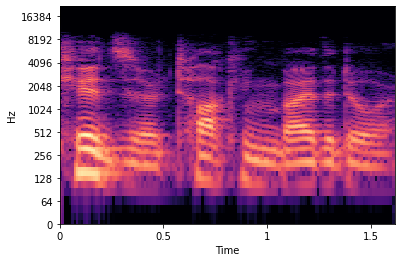

In [ ]:
lid.specshow(calm.iloc[1]['spectrogram_data'], sr=44100, x_axis="time", y_axis="log")
# lid.specshow(calm.iloc[3]['spectrogram_data'], sr=44100, x_axis='time', y_axis='log');

# print(calm.iloc[1]['spectrogram_data'])
# print((calm.iloc[1]['spectrogram_data']).shape)
# print(type(calm.iloc[1]['spectrogram_data']))